In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from IPython.display import display
from sklearn.naive_bayes import GaussianNB

import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Malicious and Benign Websites dataset
malicious_benign_df = pd.read_csv("https://storm.cis.fordham.edu/~afaid/dataset.csv")

# Load the Phishing Website Detector dataset
phishing_df = pd.read_csv("https://storm.cis.fordham.edu/~afaid/phishing.csv")

In [ ]:
print("Class distribution for phishing_df:")
print(phishing_df['class'].value_counts())

# Check the class distribution for malicious_benign_df
print("\nClass distribution for malicious_benign_df:")
print(malicious_benign_df['class'].value_counts())

Class distribution for phishing_df:
 1    6157
-1    4897
Name: class, dtype: int64

Class distribution for malicious_benign_df:
0    1565
1     216
Name: class, dtype: int64


In [ ]:
phishing_features = [
    'UsingIP', 'HTTPS', 'AgeofDomain', 'PageRank', 'WebsiteTraffic', 'AbnormalURL', 'UsingPopupWindow', 'WebsiteForwarding',
    'class'
]

malicious_benign_features = [
    'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS', 'DNS_QUERY_TIMES',
    'Type'
]

# Preprocess the phishing_df dataset
phishing_df = phishing_df[phishing_features]

# Preprocess the malicious_benign_df dataset
malicious_benign_df = malicious_benign_df[malicious_benign_features].copy()
malicious_benign_df = malicious_benign_df[malicious_benign_features]
malicious_benign_df.rename(columns={'Type': 'class'}, inplace=True)

# Fill missing values in the malicious_benign_df dataset with the mean
malicious_benign_df['DNS_QUERY_TIMES'].fillna(malicious_benign_df['DNS_QUERY_TIMES'].mean(), inplace=True)

print("Class distribution for phishing_df:")
print(phishing_df['class'].value_counts())

# Check the class distribution for malicious_benign_df
print("\nClass distribution for malicious_benign_df:")
print(malicious_benign_df['class'].value_counts())

Class distribution for phishing_df:
 1    6157
-1    4897
Name: class, dtype: int64

Class distribution for malicious_benign_df:
0    1565
1     216
Name: class, dtype: int64


In [ ]:
def evaluate_models(datasets, features_list, classifiers, classifier_params, test_size=0.2, random_state_list=[42], balancing_strategies=None):
    results = {}
    grid_results = {}
    
    for dataset, features in zip(datasets, features_list):
        dataset_name = dataset.index.name
        results[dataset_name] = {}
        
        for random_state in random_state_list:
            results[dataset_name][random_state] = {}
            
            for clf_name, clf in classifiers.items():
                results[dataset_name][random_state][clf_name] = {}
                
                for strategy_name, strategy in balancing_strategies.items():
                    X = dataset[features]
                    y = dataset['class']

                    # Train-test split
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

                    # Impute missing values with the mean
                    imputer = SimpleImputer(strategy='mean')
                    X_train = imputer.fit_transform(X_train)
                    X_test = imputer.transform(X_test)

                    # Scaling
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test)

                    if strategy is not None:
                        X_train, y_train = strategy.fit_resample(X_train, y_train)

                    # Hyperparameter tuning
                    grid = GridSearchCV(clf, classifier_params[clf_name], scoring='f1')
                    grid.fit(X_train, y_train)

                    # Train the classifier with best parameters
                    best_clf = grid.best_estimator_
                    best_clf.fit(X_train, y_train)

                    # Predict on the test set
                    y_pred = best_clf.predict(X_test)

                    # Evaluate the classifier
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    recall = recall_score(y_test, y_pred)
                    f1 = f1_score(y_test, y_pred)

                    # Store the hyperparameters in the results
                    hyperparams = str(grid.best_params_)

                    # Store the GridSearchCV results
                    grid_results_key = f"{dataset_name}_{random_state}_{clf_name}_{strategy_name}"
                    grid_results[grid_results_key] = grid.cv_results_

                    results[dataset_name][random_state][clf_name][strategy_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Hyperparameters': hyperparams}
    
    return results, grid_results

In [ ]:
def display_results_tables(results):
    for dataset_name, dataset_results in results.items():
        print(f"\n{dataset_name} dataset results:")
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
            table_data = []
            for random_state, clf_results in dataset_results.items():
                for clf_name, strategy_results in clf_results.items():
                    for strategy_name, eval_results in strategy_results.items():
                        row = {
                            'Classifier': clf_name,
                            'Balancing Strategy': strategy_name,
                            'Random State': random_state,
                            'Accuracy': eval_results['Accuracy'],
                            'Precision': eval_results['Precision'],
                            'Recall': eval_results['Recall'],
                            'F1 Score': eval_results['F1 Score'],
                            'Hyperparameters': eval_results['Hyperparameters']
                        }
                        table_data.append(row)
            table_df = pd.DataFrame(table_data)
            display_styled_table(table_df, metric)

def display_best_results_tables(results):
    for dataset_name, dataset_results in results.items():
        print(f"\nBest results for {dataset_name} dataset:")
        display_best_results_table(dataset_results, 'F1 Score')

def display_best_results_table(dataset_results, metric):
    table_data = []
    for random_state, clf_results in dataset_results.items():
        for clf_name, strategy_results in clf_results.items():
            for strategy_name, eval_results in strategy_results.items():
                row = {
                    'Classifier': clf_name,
                    'Balancing Strategy': strategy_name,
                    'Random State': random_state,
                    'Accuracy': eval_results['Accuracy'],
                    'Precision': eval_results['Precision'],
                    'Recall': eval_results['Recall'],
                    'F1 Score': eval_results['F1 Score'],
                    'Hyperparameters': eval_results['Hyperparameters']
                }
                table_data.append(row)
    table_df = pd.DataFrame(table_data)
    
    # Sort by the desired metric in descending order
    table_df = table_df.sort_values(by=[metric], ascending=False)

    # Remove duplicates, keeping only the best result for each combination
    table_df = table_df.drop_duplicates(subset=['Classifier', 'Balancing Strategy'], keep='first')

    print(f"\nBest {metric}:")
    display(table_df.style.set_caption(metric).set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]}
    ]))


def display_styled_table(table, metric):
    print(f"\n{metric}:")
    display(table.style.set_caption(metric).set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]}
    ]))

In [ ]:
# Set the index name for each dataset
phishing_df.index.name = 'Phishing'
malicious_benign_df.index.name = 'Malicious and Benign'

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "GaussianNB": GaussianNB(),
    "KNeighbors": KNeighborsClassifier()
}

# Classifier parameters for hyperparameter tuning
classifier_params = {
    "RandomForest": {"n_estimators": [5, 10, 20, 30, 50, 100]},
    "GaussianNB": {},
    "KNeighbors": {"n_neighbors": [3, 5, 7, 9, 11]}
}

# Balancing strategies
balancing_strategies = {
    'None': None,
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN()
}

# Number of random states to try
random_state_list = [42, 123, 456, 789]

# Evaluate classifiers
datasets = [phishing_df, malicious_benign_df]
features_list = [phishing_features[:-1], malicious_benign_features[:-1]]
results, grid_results = evaluate_models(datasets, features_list, classifiers, classifier_params, random_state_list=random_state_list, balancing_strategies=balancing_strategies)

# Display results in tables
display_results_tables(results)

# Display the best results in tables
display_best_results_tables(results)


Phishing dataset results:

Accuracy:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.888738,0.913116,0.885020,0.898849,{'n_estimators': 20}
1,RandomForest,SMOTE,42,0.889643,0.913952,0.885830,0.899671,{'n_estimators': 20}
2,RandomForest,ADASYN,42,0.877883,0.929653,0.845344,0.885496,{'n_estimators': 30}
3,GaussianNB,None,42,0.878788,0.868802,0.922267,0.894737,{}
4,GaussianNB,SMOTE,42,0.881049,0.872129,0.922267,0.896497,{}
5,GaussianNB,ADASYN,42,0.862506,0.869151,0.887449,0.878205,{}
6,KNeighbors,None,42,0.870194,0.850592,0.931174,0.889061,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.870647,0.851221,0.931174,0.889404,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.870647,0.851742,0.930364,0.889319,{'n_neighbors': 5}
9,RandomForest,None,123,0.890095,0.893634,0.909016,0.901260,{'n_estimators': 10}



Precision:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.888738,0.913116,0.885020,0.898849,{'n_estimators': 20}
1,RandomForest,SMOTE,42,0.889643,0.913952,0.885830,0.899671,{'n_estimators': 20}
2,RandomForest,ADASYN,42,0.877883,0.929653,0.845344,0.885496,{'n_estimators': 30}
3,GaussianNB,None,42,0.878788,0.868802,0.922267,0.894737,{}
4,GaussianNB,SMOTE,42,0.881049,0.872129,0.922267,0.896497,{}
5,GaussianNB,ADASYN,42,0.862506,0.869151,0.887449,0.878205,{}
6,KNeighbors,None,42,0.870194,0.850592,0.931174,0.889061,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.870647,0.851221,0.931174,0.889404,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.870647,0.851742,0.930364,0.889319,{'n_neighbors': 5}
9,RandomForest,None,123,0.890095,0.893634,0.909016,0.901260,{'n_estimators': 10}



Recall:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.888738,0.913116,0.885020,0.898849,{'n_estimators': 20}
1,RandomForest,SMOTE,42,0.889643,0.913952,0.885830,0.899671,{'n_estimators': 20}
2,RandomForest,ADASYN,42,0.877883,0.929653,0.845344,0.885496,{'n_estimators': 30}
3,GaussianNB,None,42,0.878788,0.868802,0.922267,0.894737,{}
4,GaussianNB,SMOTE,42,0.881049,0.872129,0.922267,0.896497,{}
5,GaussianNB,ADASYN,42,0.862506,0.869151,0.887449,0.878205,{}
6,KNeighbors,None,42,0.870194,0.850592,0.931174,0.889061,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.870647,0.851221,0.931174,0.889404,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.870647,0.851742,0.930364,0.889319,{'n_neighbors': 5}
9,RandomForest,None,123,0.890095,0.893634,0.909016,0.901260,{'n_estimators': 10}



F1 Score:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.888738,0.913116,0.885020,0.898849,{'n_estimators': 20}
1,RandomForest,SMOTE,42,0.889643,0.913952,0.885830,0.899671,{'n_estimators': 20}
2,RandomForest,ADASYN,42,0.877883,0.929653,0.845344,0.885496,{'n_estimators': 30}
3,GaussianNB,None,42,0.878788,0.868802,0.922267,0.894737,{}
4,GaussianNB,SMOTE,42,0.881049,0.872129,0.922267,0.896497,{}
5,GaussianNB,ADASYN,42,0.862506,0.869151,0.887449,0.878205,{}
6,KNeighbors,None,42,0.870194,0.850592,0.931174,0.889061,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.870647,0.851221,0.931174,0.889404,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.870647,0.851742,0.930364,0.889319,{'n_neighbors': 5}
9,RandomForest,None,123,0.890095,0.893634,0.909016,0.901260,{'n_estimators': 10}



Malicious and Benign dataset results:

Accuracy:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.932773,0.885714,0.607843,0.720930,{'n_estimators': 50}
1,RandomForest,SMOTE,42,0.924370,0.772727,0.666667,0.715789,{'n_estimators': 30}
2,RandomForest,ADASYN,42,0.913165,0.678571,0.745098,0.710280,{'n_estimators': 50}
3,GaussianNB,None,42,0.235294,0.157407,1.000000,0.272000,{}
4,GaussianNB,SMOTE,42,0.238095,0.157895,1.000000,0.272727,{}
5,GaussianNB,ADASYN,42,0.201681,0.151786,1.000000,0.263566,{}
6,KNeighbors,None,42,0.907563,0.736842,0.549020,0.629213,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.876751,0.550725,0.745098,0.633333,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.879552,0.558824,0.745098,0.638655,{'n_neighbors': 3}
9,RandomForest,None,123,0.960784,0.916667,0.750000,0.825000,{'n_estimators': 100}



Precision:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.932773,0.885714,0.607843,0.720930,{'n_estimators': 50}
1,RandomForest,SMOTE,42,0.924370,0.772727,0.666667,0.715789,{'n_estimators': 30}
2,RandomForest,ADASYN,42,0.913165,0.678571,0.745098,0.710280,{'n_estimators': 50}
3,GaussianNB,None,42,0.235294,0.157407,1.000000,0.272000,{}
4,GaussianNB,SMOTE,42,0.238095,0.157895,1.000000,0.272727,{}
5,GaussianNB,ADASYN,42,0.201681,0.151786,1.000000,0.263566,{}
6,KNeighbors,None,42,0.907563,0.736842,0.549020,0.629213,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.876751,0.550725,0.745098,0.633333,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.879552,0.558824,0.745098,0.638655,{'n_neighbors': 3}
9,RandomForest,None,123,0.960784,0.916667,0.750000,0.825000,{'n_estimators': 100}



Recall:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.932773,0.885714,0.607843,0.720930,{'n_estimators': 50}
1,RandomForest,SMOTE,42,0.924370,0.772727,0.666667,0.715789,{'n_estimators': 30}
2,RandomForest,ADASYN,42,0.913165,0.678571,0.745098,0.710280,{'n_estimators': 50}
3,GaussianNB,None,42,0.235294,0.157407,1.000000,0.272000,{}
4,GaussianNB,SMOTE,42,0.238095,0.157895,1.000000,0.272727,{}
5,GaussianNB,ADASYN,42,0.201681,0.151786,1.000000,0.263566,{}
6,KNeighbors,None,42,0.907563,0.736842,0.549020,0.629213,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.876751,0.550725,0.745098,0.633333,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.879552,0.558824,0.745098,0.638655,{'n_neighbors': 3}
9,RandomForest,None,123,0.960784,0.916667,0.750000,0.825000,{'n_estimators': 100}



F1 Score:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
0,RandomForest,None,42,0.932773,0.885714,0.607843,0.720930,{'n_estimators': 50}
1,RandomForest,SMOTE,42,0.924370,0.772727,0.666667,0.715789,{'n_estimators': 30}
2,RandomForest,ADASYN,42,0.913165,0.678571,0.745098,0.710280,{'n_estimators': 50}
3,GaussianNB,None,42,0.235294,0.157407,1.000000,0.272000,{}
4,GaussianNB,SMOTE,42,0.238095,0.157895,1.000000,0.272727,{}
5,GaussianNB,ADASYN,42,0.201681,0.151786,1.000000,0.263566,{}
6,KNeighbors,None,42,0.907563,0.736842,0.549020,0.629213,{'n_neighbors': 5}
7,KNeighbors,SMOTE,42,0.876751,0.550725,0.745098,0.633333,{'n_neighbors': 5}
8,KNeighbors,ADASYN,42,0.879552,0.558824,0.745098,0.638655,{'n_neighbors': 3}
9,RandomForest,None,123,0.960784,0.916667,0.750000,0.825000,{'n_estimators': 100}



Best results for Phishing dataset:

Best F1 Score:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
27,RandomForest,None,789,0.902307,0.907774,0.926128,0.916859,{'n_estimators': 50}
28,RandomForest,SMOTE,789,0.902307,0.930064,0.899689,0.914625,{'n_estimators': 50}
29,RandomForest,ADASYN,789,0.898236,0.931652,0.890358,0.910537,{'n_estimators': 20}
31,GaussianNB,SMOTE,789,0.888738,0.885185,0.929238,0.906677,{}
30,GaussianNB,None,789,0.886477,0.881919,0.929238,0.904960,{}
34,KNeighbors,SMOTE,789,0.887834,0.933946,0.868585,0.900081,{'n_neighbors': 7}
32,GaussianNB,ADASYN,789,0.881049,0.882001,0.918351,0.899810,{}
35,KNeighbors,ADASYN,789,0.884668,0.929226,0.867807,0.897467,{'n_neighbors': 5}
15,KNeighbors,None,123,0.884668,0.912746,0.874590,0.893261,{'n_neighbors': 9}



Best results for Malicious and Benign dataset:

Best F1 Score:


,Classifier,Balancing Strategy,Random State,Accuracy,Precision,Recall,F1 Score,Hyperparameters
9,RandomForest,None,123,0.960784,0.916667,0.750000,0.825000,{'n_estimators': 100}
10,RandomForest,SMOTE,123,0.943978,0.730769,0.863636,0.791667,{'n_estimators': 50}
11,RandomForest,ADASYN,123,0.932773,0.678571,0.863636,0.760000,{'n_estimators': 50}
24,KNeighbors,None,456,0.938375,0.702703,0.702703,0.702703,{'n_neighbors': 3}
8,KNeighbors,ADASYN,42,0.879552,0.558824,0.745098,0.638655,{'n_neighbors': 3}
16,KNeighbors,SMOTE,123,0.879552,0.506667,0.863636,0.638655,{'n_neighbors': 3}
4,GaussianNB,SMOTE,42,0.238095,0.157895,1.000000,0.272727,{}
3,GaussianNB,None,42,0.235294,0.157407,1.000000,0.272000,{}
5,GaussianNB,ADASYN,42,0.201681,0.151786,1.000000,0.263566,{}


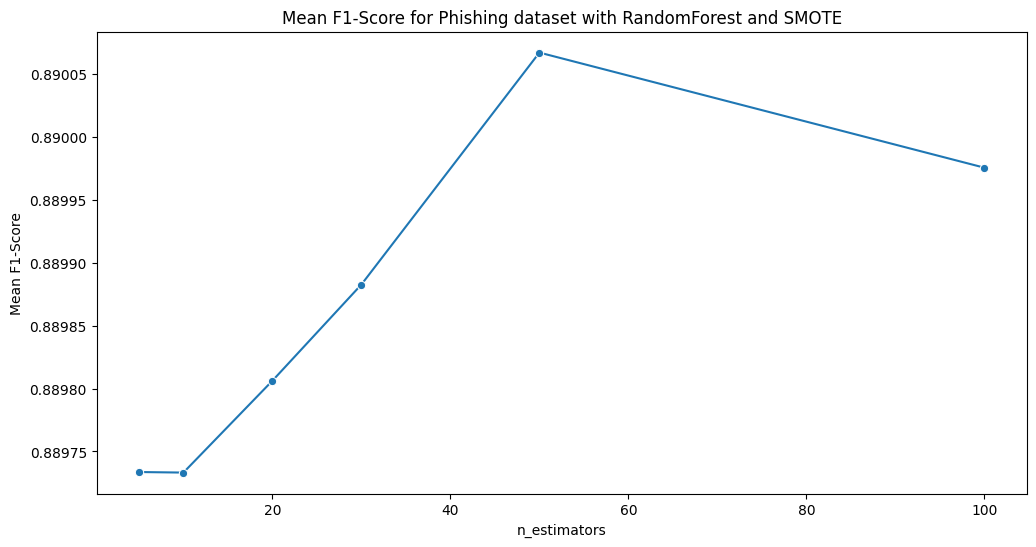

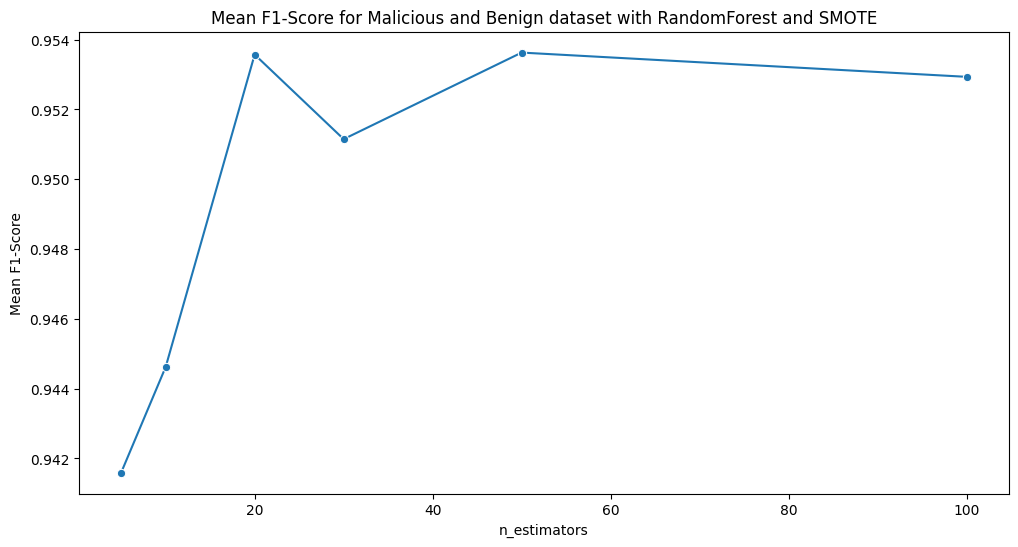

In [ ]:
def plot_f1_scores(grid_results, dataset_name, random_state, classifier_name, balancing_strategy_name, param_name):
    key = f"{dataset_name}_{random_state}_{classifier_name}_{balancing_strategy_name}"
    data = None

    for k, v in grid_results.items():
        if key in k:
            data = v
            break

    if data is None:
        print(f"No results found for {key}")
        return

    mean_f1_scores = data['mean_test_score']
    params = data['params']

    df = pd.DataFrame(params)
    df['mean_f1_score'] = mean_f1_scores

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=param_name, y='mean_f1_score', marker='o')
    plt.title(f"Mean F1-Score for {dataset_name} dataset with {classifier_name} and {balancing_strategy_name}")
    plt.xlabel(param_name)
    plt.ylabel("Mean F1-Score")
    plt.show()

dataset_name = "Phishing"
random_state = 789
classifier_name = "RandomForest"
balancing_strategy_name = "SMOTE"
param_name = "n_estimators"
plot_f1_scores(grid_results, dataset_name, random_state, classifier_name, balancing_strategy_name, param_name)

dataset_name = "Malicious and Benign"
random_state = 123
classifier_name = "RandomForest"
balancing_strategy_name = "SMOTE"
param_name = "n_estimators"
plot_f1_scores(grid_results, dataset_name, random_state, classifier_name, balancing_strategy_name, param_name)

In [ ]:
def get_feature_importances(dataset, features, n_estimators=100, random_state=42):
    X = dataset[features]
    y = dataset['class']

    # Create the classifier
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Train the classifier
    clf.fit(X, y)
    
    # Get feature importances
    importances = clf.feature_importances_
    
    # Create a DataFrame with feature names and their importance scores
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    return importance_df

# Get feature importances for the phishing_df dataset
phishing_importance_df = get_feature_importances(phishing_df, phishing_features[:-1])

print("Phishing dataset feature importances:")
display(phishing_importance_df)

# Get feature importances for the malicious_benign_df dataset
malicious_benign_importance_df = get_feature_importances(malicious_benign_df, malicious_benign_features[:-1])

print("\nMalicious and Benign Websites dataset feature importances:")
display(malicious_benign_importance_df)

Phishing dataset feature importances:


,Feature,Importance
1,HTTPS,0.758756
4,WebsiteTraffic,0.146818
0,UsingIP,0.022707
2,AgeofDomain,0.018217
3,PageRank,0.017107
6,UsingPopupWindow,0.013405
5,AbnormalURL,0.012749
7,WebsiteForwarding,0.010241



Malicious and Benign Websites dataset feature importances:


,Feature,Importance
1,APP_BYTES,0.188875
4,SOURCE_APP_BYTES,0.178954
5,REMOTE_APP_BYTES,0.174767
3,REMOTE_APP_PACKETS,0.152566
0,REMOTE_IPS,0.094299
6,APP_PACKETS,0.085411
2,SOURCE_APP_PACKETS,0.076158
7,DNS_QUERY_TIMES,0.048970


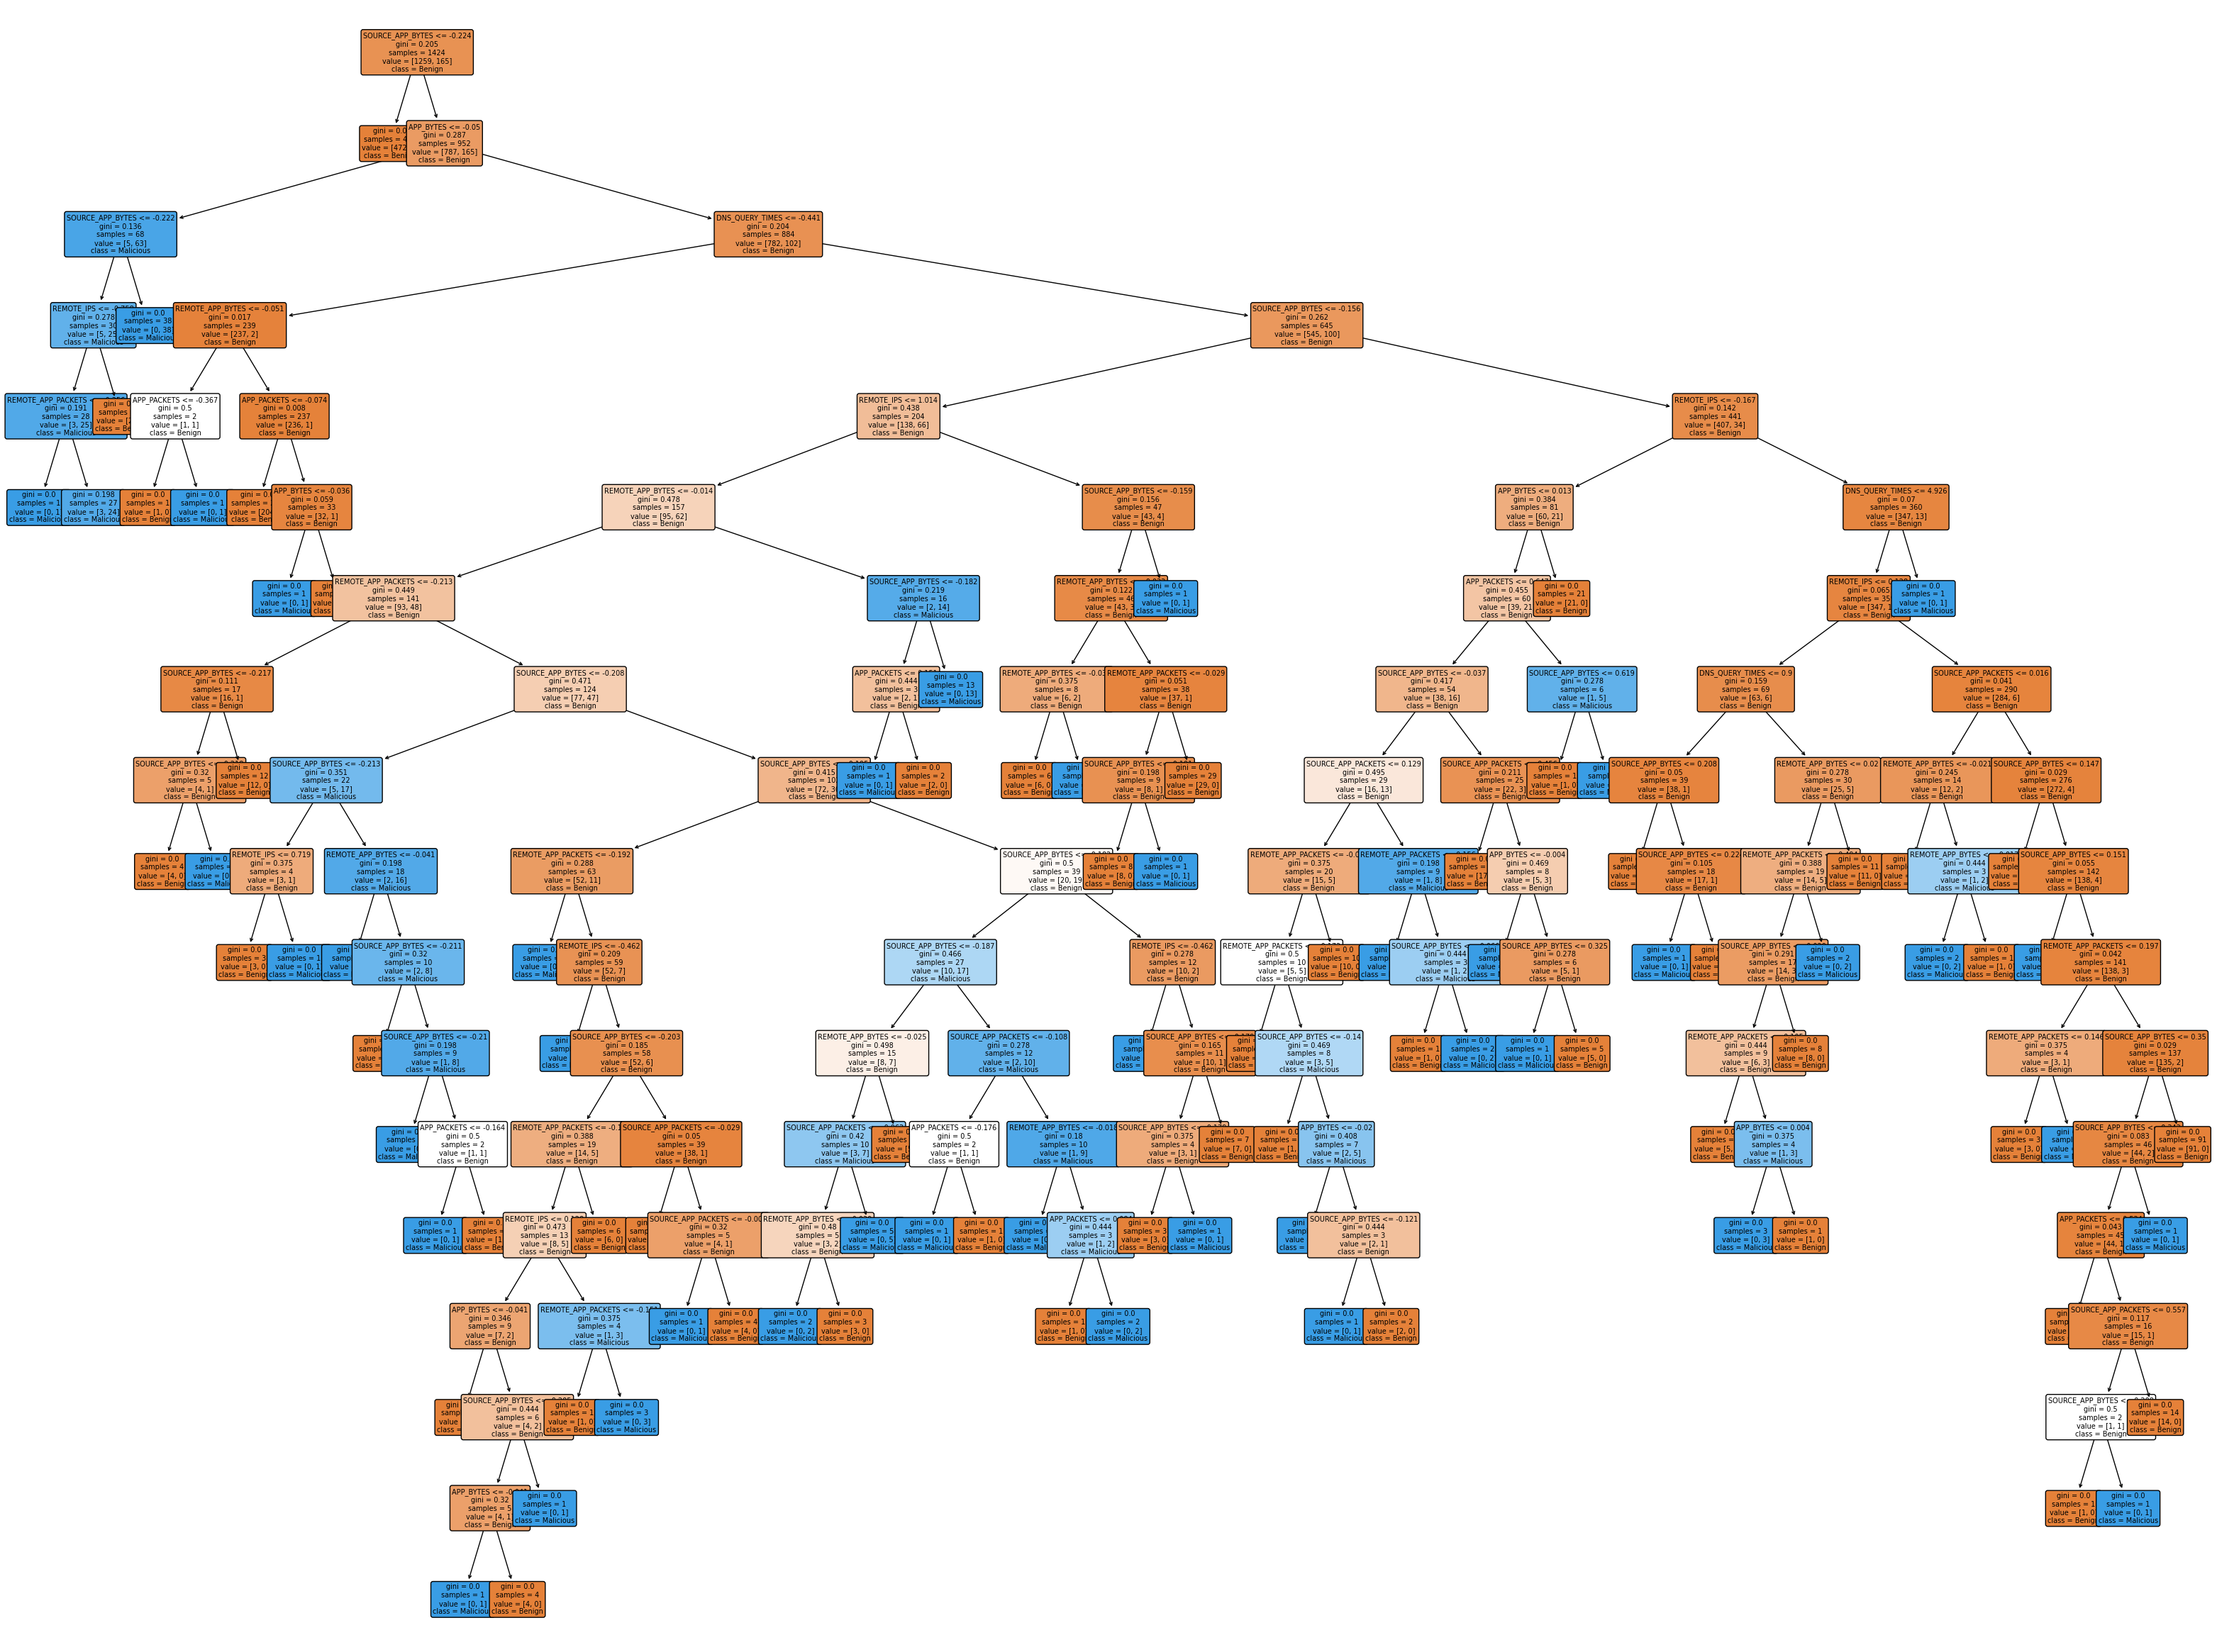

In [ ]:
# Train a single DecisionTreeClassifier on the malicious_benign_df dataset
X = malicious_benign_df[malicious_benign_features[:-1]]
y = malicious_benign_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(40, 30))
plot_tree(dt_clf, feature_names=malicious_benign_features[:-1], class_names=['Benign', 'Malicious'], filled=True, rounded=True, fontsize=7)
plt.show()

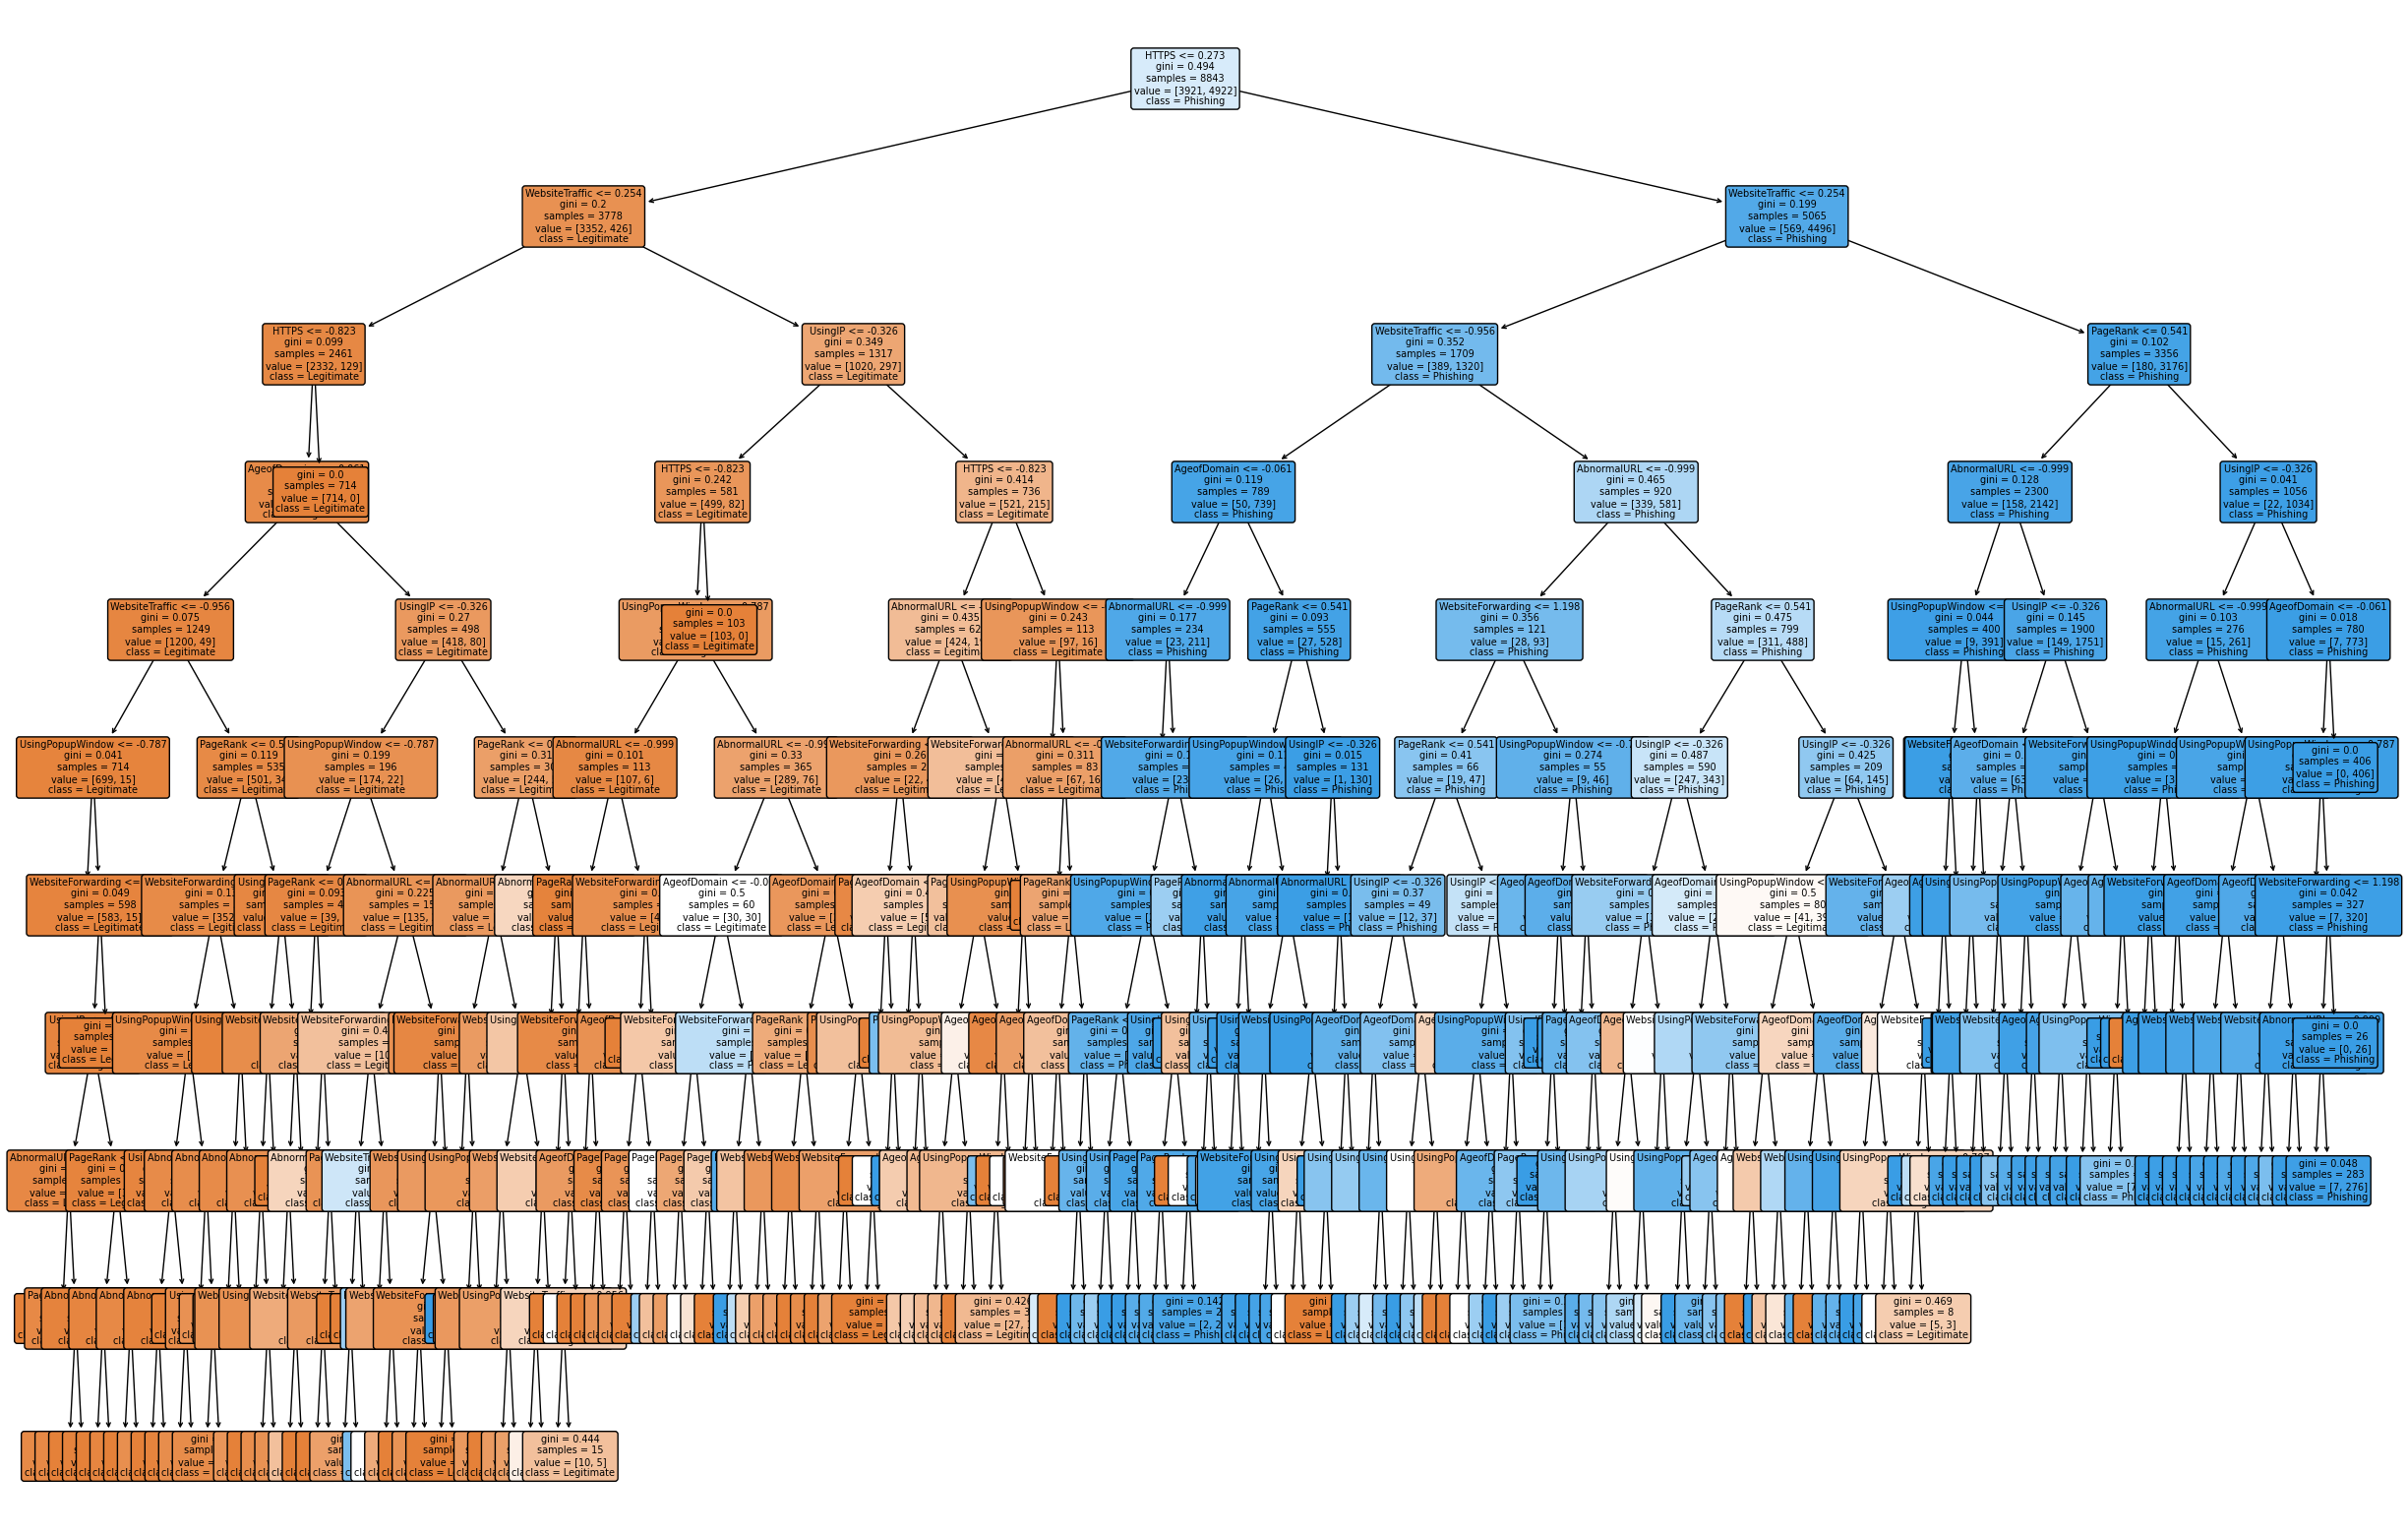

In [ ]:
# Train a single DecisionTreeClassifier on the phishing_df dataset
X = phishing_df[phishing_features[:-1]]
y = phishing_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(dt_clf, feature_names=phishing_features[:-1], class_names=['Legitimate', 'Phishing'], filled=True, rounded=True, fontsize=7)
plt.show()

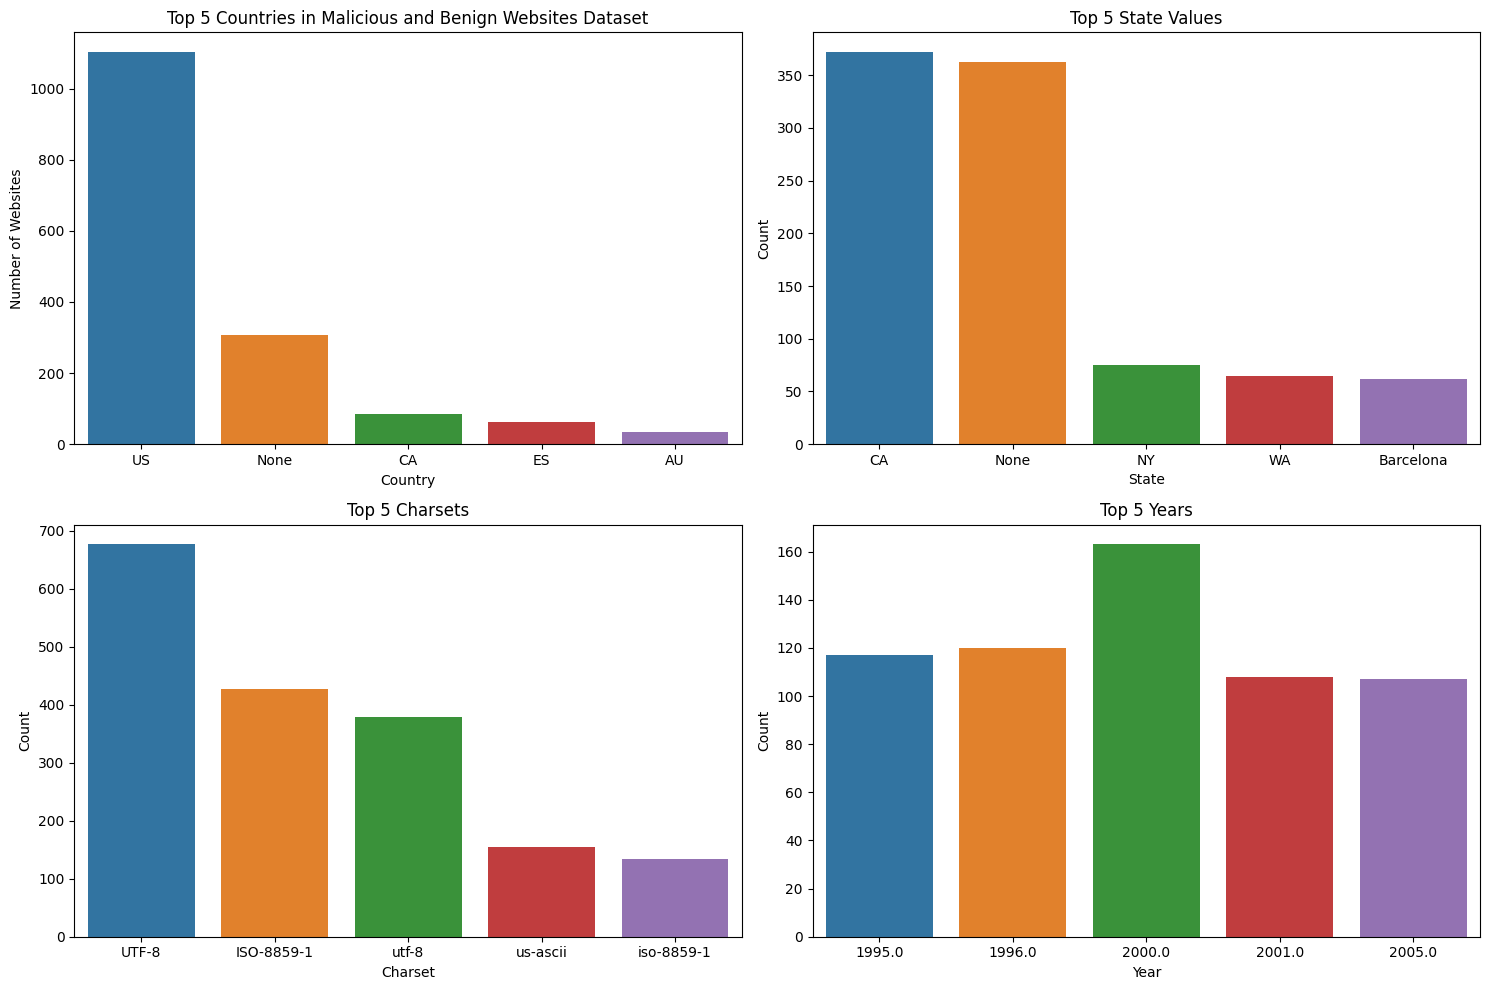

In [ ]:
# Load the Malicious and Benign Websites dataset
malicious_benign_full_df = pd.read_csv("https://storm.cis.fordham.edu/~afaid/dataset.csv")

# Get the value counts of the WHOIS_COUNTRY and CHARSET columns and select the top 5
top_5_countries = malicious_benign_full_df['WHOIS_COUNTRY'].value_counts().head(5)
top_5_states = malicious_benign_full_df['WHOIS_STATEPRO'].value_counts().nlargest(5)
top_5_charsets = malicious_benign_full_df['CHARSET'].value_counts().nlargest(5)

# Get the year from the WHOIS_REGDATE column
malicious_benign_full_df['WHOIS_REGDATE'] = pd.to_datetime(malicious_benign_full_df['WHOIS_REGDATE'], format='%d/%m/%Y %H:%M', errors='coerce')
malicious_benign_full_df['Year'] = malicious_benign_full_df['WHOIS_REGDATE'].dt.year
top_5_years = malicious_benign_full_df['Year'].value_counts().nlargest(5)

# Create the subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top 5 countries
sns.barplot(x=top_5_countries.index, y=top_5_countries.values, ax=axs[0, 0])
axs[0, 0].set_title("Top 5 Countries in Malicious and Benign Websites Dataset")
axs[0, 0].set_xlabel("Country")
axs[0, 0].set_ylabel("Number of Websites")

# Plot the top 5 states
sns.barplot(x=top_5_states.index, y=top_5_states.values, ax=axs[0, 1])
axs[0, 1].set_title('Top 5 State Values')
axs[0, 1].set_xlabel('State')
axs[0, 1].set_ylabel('Count')

# Plot the top 5 charsets
sns.barplot(x=top_5_charsets.index, y=top_5_charsets.values, ax=axs[1, 0])
axs[1, 0].set_title('Top 5 Charsets')
axs[1, 0].set_xlabel('Charset')
axs[1, 0].set_ylabel('Count')

# Plot the top 5 years
sns.barplot(x=top_5_years.index, y=top_5_years.values, ax=axs[1, 1])
axs[1, 1].set_title('Top 5 Years')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


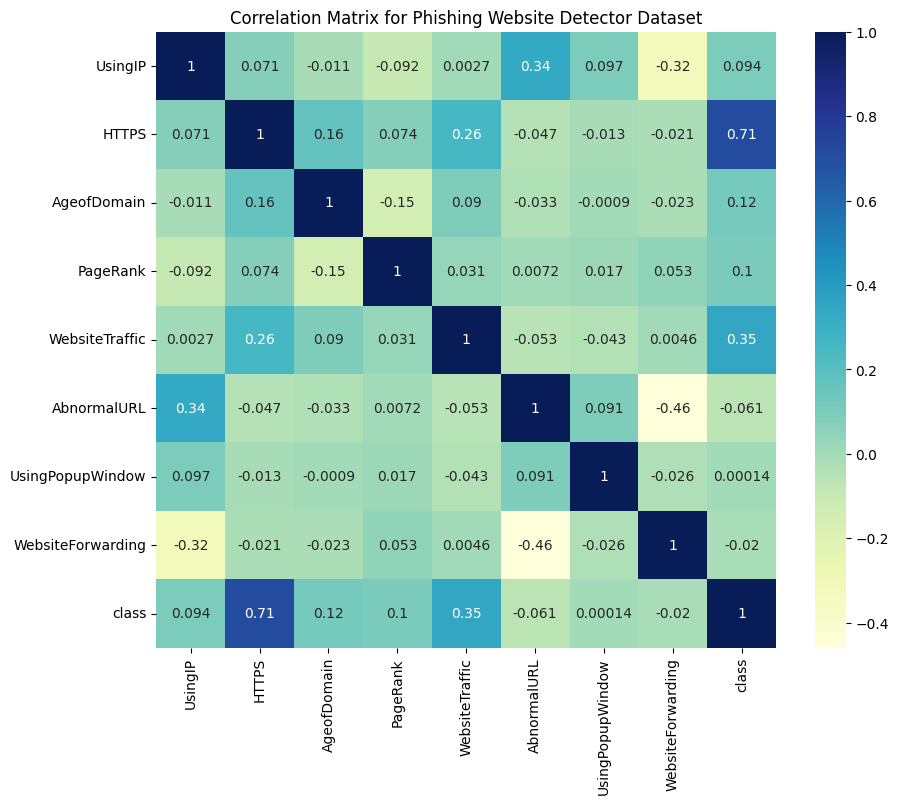

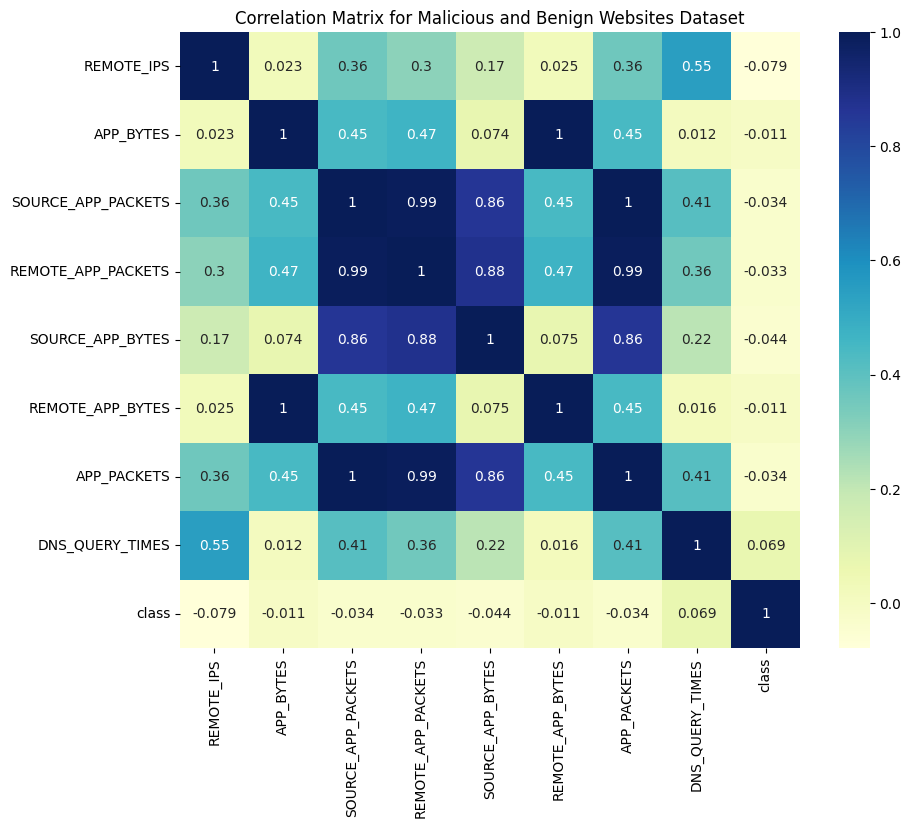

In [ ]:
# Create the correlation matrix for phishing_df
phishing_corr = phishing_df.corr()

# Create the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(phishing_corr, annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix for Phishing Website Detector Dataset')
plt.show()

# Create the correlation matrix for malicious_benign_df
malicious_benign_corr = malicious_benign_df.corr()

# Create the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(malicious_benign_corr, annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix for Malicious and Benign Websites Dataset')
plt.show()